# Hybrid CNN-LSTM Model using GloVe vector for Sentiment Analysis of Football Specific Tweets

## Libraries

In [1]:
import os
# Regular expressions
import re

# Data and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculations
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Deep Learning
import tensorflow as tf

2022-05-28 18:32:13.381013: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Exploring the Dataset

### Load

In [2]:
dataset = pd.read_csv("/kaggle/input/twitter-sentiment-analysis-and-word-embeddings/Dataset/Dataset/training_dataset.csv", encoding="latin", header=None,
                      names=["target","id", "date","query","username","tweet"])

### Show some Examples

In [3]:
dataset.head(5)

,target,id,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Check for Missing Values

In [4]:
print(f"Missing values: \n\n{dataset.isna().sum()}")

Missing values: 

target      0
id          0
date        0
query       0
username    0
tweet       0
dtype: int64


```
There are 0 missing values within this dataset
```

## Target Distribution

### Negative samples (*target=4*)

In [5]:
negative_samples = dataset[dataset["target"]==0]
print(f"Number of negative samples : {len(negative_samples)}\n")
negative_samples.head(5)

Number of negative samples : 800000



,target,id,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Neutral samples (*target=4*)

In [6]:
neutral_samples = dataset[dataset["target"]==2]
print(f"Number of neutral samples : {len(neutral_samples)}\n\n")
neutral_samples.head(5)

Number of neutral samples : 0




,target,id,date,query,username,tweet


```
0 neutral sample ? Wow
```

### Positive samples (*target=4*)

In [7]:
positive_samples = dataset[dataset["target"]==4]
print(f"Number of positive samples {len(positive_samples)}\n\n")
positive_samples.head(5)

Number of positive samples 800000




,target,id,date,query,username,tweet
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


### Distribution Plot

#### Defining data

In [8]:
data = [len(negative_samples), len(neutral_samples), len(positive_samples)]
labels = ["Negative","Neutral","Positive"]

In [9]:
colors = sns.color_palette("pastel")


#### Distribution Pie-chart

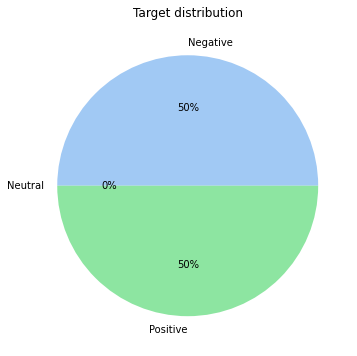

In [10]:
plt.figure(figsize=(6,6))
plt.title("Target distribution")
plt.pie(data, labels=labels, colors=colors, autopct="%.0f%%")
plt.show()

# Data cleaning

## Drop unncessary columns
These columns are not necessary to train our model : ID, date, query, username.

> Notes :
- axis = 1 means "computing along the columns"
- using (inplace = true) will overwrite the existing dataframe

In [11]:
dataset.drop(["id","date","query","username"],axis=1, inplace=True)

### Result

In [12]:
dataset.head(5)

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Replace the targets

In the original dataset, 4 means "true". For convenience purposes, we'll set it to 1.

In [13]:
dataset.target = dataset.target.replace({4: 1})

### Result

In [14]:
dataset[dataset["target"]==1].head()

,target,tweet
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


## Removing mentions, links, extra spaces from tweets

In [15]:
# Remove mentions
regex_mentions = r"@[A-Za-z0-9_]+"
# Remove links
regex_links = r"https?://[A-Za-z0-9./]+"
# Remove some special characters
regex_special = r"[^A-Za-z0-9]+"

### Apply preprocessing

In [16]:
# Remove mentions
dataset.tweet = dataset.tweet.apply(lambda x: re.sub(regex_mentions, " ", str(x).strip()))
# Remove links
dataset.tweet = dataset.tweet.apply(lambda x: re.sub(regex_links, " ", str(x).strip()))
# Remove special characters
dataset.tweet = dataset.tweet.apply(lambda x: re.sub(regex_special, " ", str(x).strip()))

### Show Results

In [17]:
dataset.head(10)

,target,tweet
0,0,Awww that s a bummer You shoulda got David Ca...
1,0,is upset that he can t update his Facebook by ...
2,0,I dived many times for the ball Managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am i h...
5,0,not the whole crew
6,0,Need a hug
7,0,hey long time no see Yes Rains a bit only a bi...
8,0,nope they didn t have it
9,0,que me muera


## Check for null content after cleaning
In some rare cases, tweets may contain only special characters and end up "empty" after cleaning

In [18]:
print(f"Null values: \n\n{dataset.isna().sum()}")

Null values: 

target    0
tweet     0
dtype: int64


In [19]:
dataset['tweet'] = dataset['tweet'].str.lower()

In [20]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because",
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [21]:
dataset['tweet'] = dataset['tweet'].apply(lambda x : ' '.join([word for word in x.split() if word not in stopwords]))

In [22]:
dataset.head(5)

,target,tweet
0,0,awww s bummer shoulda got david carr third day d
1,0,upset can t update facebook texting might cry ...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,no s not behaving m mad can t see


# Data preparation

## Train/test split

Since the dataset is large enough, we will proceed to a 90-10 (90% for training and 10% for validation/test) split.

> Note : Fixing the random state parameter makes our splitting operation reproductible by initializing the internal random number generator which will decide the splitting of data into train and test indices in our case.

In [23]:
train, test = train_test_split(dataset, test_size=0.1, random_state=44)

### Results

In [24]:
print(f"Training set length: {len(train)/1e6}M examples")
print(f"Test set length: {len(test)/1e6}M examples")

Training set length: 1.44M examples
Test set length: 0.16M examples


## Tokenization

Tokenization is the process of breaking apart original text into individual pieces (tokens) for further analysis. This process is important because the meaning of the text can be interpreted through analysis of the words present in the text.

### Define the tokenizer

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf

In [25]:
# Initialize the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# Updates the internal vocabulary based on our tweet contents
tokenizer.fit_on_texts(train.tweet)
# Setup the vocabular size based on the tokenizer results
vocab_size = len(tokenizer.word_index)+1

### Results

In [26]:
print(f"Word index length: {len(tokenizer.word_index)}")
print(f"Some words: {list(tokenizer.word_index.keys())[0:10]}")

Word index length: 268078
Some words: ['s', 't', 'm', 'just', 'not', 'now', 'can', 'good', 'day', 'get']


### Get the max token length

In [27]:
# Intialize the mex length to the first tweet length
max_length = len(dataset["tweet"][0].split())

# Loop through the tweets
for tweet in dataset["tweet"]:
    # Get each tweet's length
    length = len(tweet.split())
    # Update the max length if greater
    if length > max_length:
        max_length = length

print(f"Maximum token length: {max_length}")

Maximum token length: 51


## Define sequences

The Tensorlow "texts_to_sequences" method transforms each text in texts to a sequence of integers.

In [28]:
# Training set
sequences_train = tokenizer.texts_to_sequences(train.tweet)
# Test set
sequences_test = tokenizer.texts_to_sequences(test.tweet)

## Define the training and test sets

In [29]:
# Pad the training sequences to the same length after the sequence
X_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_length, padding="post")
# Pad the test sequences to the same length after the sequence
X_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_length, padding="post")

# Setup the training target
y_train = train.target.values
# Setup the test target values
y_test = test.target.values

print(f"Training test shape : {X_train.shape}")

Training test shape : (1440000, 51)


## Embedding with Word Embeddings (GloVe)

- Embedding is an approach that allows us to give a numeric representation of words. The Word Embeddings method setup words with similar meaning to have a similar representation.
- To sum up briefly, the GloVe dataset is a model for distributed word representation pre-trained on a very large corpus. Our GloVe dataset contains 100-dimensional pretrained words, with each row containing the actual word followed by its 100-dimensional representation.

### Setup embeddings

In [30]:
embeddings_dictionary = dict()
embedding_dimension = 100
glove_file = open("/kaggle/input/glovetwitter27b/glove.twitter.27B.100d.txt", encoding="utf8")

### Apply word embedding

In [31]:
# Iterate through the glove file
for line in glove_file:
    # Split each line
    records = line.split()
    # Get the actual word
    word = records[0]
    # Get the dimensional representation
    representation = np.asarray(records[1:], dtype="float32")
    # Update the words dictionary
    embeddings_dictionary[word] = representation

# Close the file
glove_file.close()

# Initialize the embedding_matrix
embeddings_matrix = np.zeros((vocab_size, embedding_dimension))

# Iterate through the tokenizer words list
for word, index in tokenizer.word_index.items():
    # Get the word representation
    embedding_vector = embeddings_dictionary.get(word)
    # Update the word representation if it exist in our dictionary
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector


# Define the model

## Set the training parameters

In [32]:
num_epochs = 50
batch_size = 1000

## Define the embedding layer

In [33]:
embedding_layer = tf.keras.layers.Embedding(
                            vocab_size,
                            embedding_dimension,
                            input_length=max_length,
                            weights=[embeddings_matrix],
                            trainable=False
)

## Define the callback : Early Stopping
We setup the Early Stopping callback to stop the training process if the **validation accuracy** stops increasing after 10 epochs, and restore the weights which minimize the validation accuracy.
Important parameters :
- **Monitor :** keras will stop training when the monitored metric has stopped improving. The direction (minimze or maximize) is automatically infered from the monitored quantity name, although it remains adjustable with the "mode" parameter
- **Patience :** the number of epochs without improvement after which the callback will be triggered (i.e, the model will stop training)
- **Restore best weights :** tells the model to restore the weights from the "best" epoch according to the monitored value

In [34]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode ="max",
    verbose=2,
    restore_best_weights=True
)

In [35]:
!mkdir training_1
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Create the model

Architecture :

- The embedding layer defined before
- 1 D CNN Layer
- Max Pooling Layer
- 3 Bidirectional LSTM layers followed by dropout layers
- Dense Layer

To sum up :
- Recurrent neural networks can obtain context information but the order
of words will lead to bias;
- The text analysis method based on Convolutional neural network (CNN) can obtain important features of text through pooling but it is difficult to obtain contextual information.

In [36]:
hybrid_cnn_lstm_model = tf.keras.models.Sequential([
        embedding_layer,
        tf.keras.layers.Conv1D(filters=embedding_dimension, kernel_size=3, padding='same',input_shape = (max_length,), activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

2022-05-28 18:35:36.734385: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-28 18:35:36.738355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-28 18:35:36.808468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 18:35:36.809493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-05-28 18:35:36.809551: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-28 18:35:36.858587: I tensorflow/stream_executor/platform/def

### Compile the Model

In [37]:
hybrid_cnn_lstm_model.compile(
       optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
       loss="binary_crossentropy",
       metrics=["accuracy"]
  )

### Model Summary

In [38]:
hybrid_cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51, 100)           26807900  
_________________________________________________________________
conv1d (Conv1D)              (None, 51, 100)           30100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 25, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

### Plot the model architecture

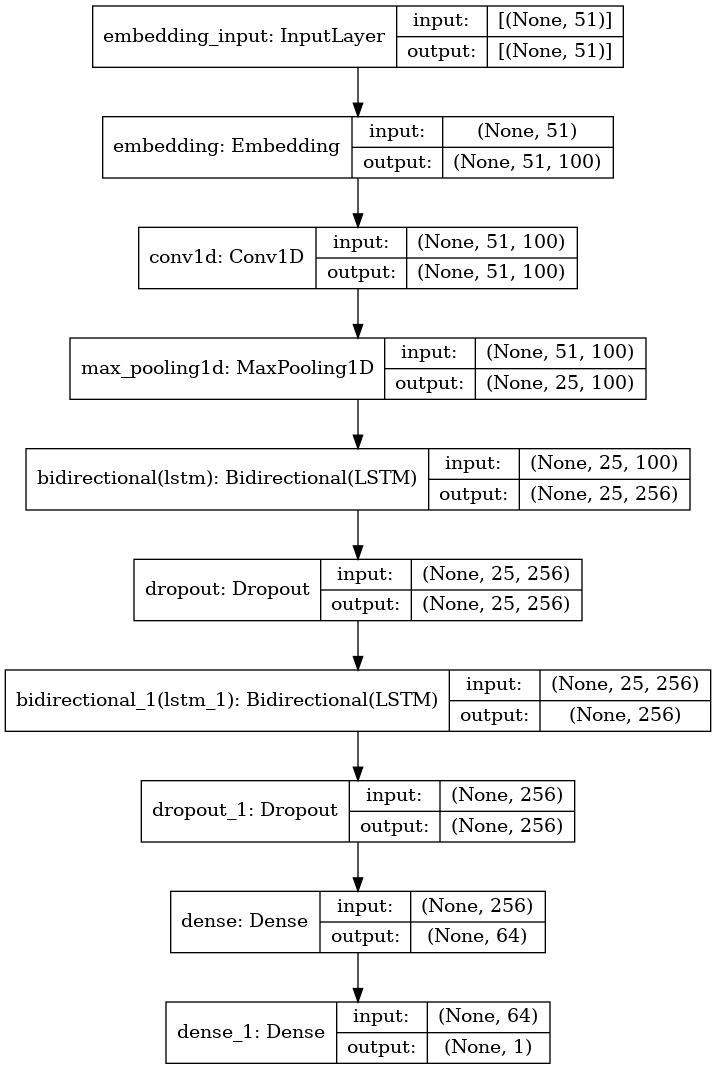

In [39]:
tf.keras.utils.plot_model(hybrid_cnn_lstm_model, show_shapes=True)

### Train the Model

In [40]:
history = hybrid_cnn_lstm_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_test,y_test),
    callbacks = [stop_early, cp_callback]
)

2022-05-28 18:35:44.818957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-28 18:35:44.832789: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/50


2022-05-28 18:35:50.101115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-28 18:35:51.188457: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-05-28 18:35:51.230714: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1440/1440 [==============================] - 81s 47ms/step - loss: 0.5413 - accuracy: 0.7208 - val_loss: 0.4706 - val_accuracy: 0.7742

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/50
1440/1440 [==============================] - 66s 46ms/step - loss: 0.4648 - accuracy: 0.7782 - val_loss: 0.4566 - val_accuracy: 0.7833

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/50
1440/1440 [==============================] - 66s 46ms/step - loss: 0.4500 - accuracy: 0.7877 - val_loss: 0.4466 - val_accuracy: 0.7896

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/50
1440/1440 [==============================] - 66s 46ms/step - loss: 0.4424 - accuracy: 0.7924 - val_loss: 0.4413 - val_accuracy: 0.7930

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/50
1440/1440 [==============================] - 65s 45ms/step - loss: 0.4360 - accuracy: 0.7962 - val_loss: 0.4378 - val_accuracy: 0.7951

Epoch 00005: saving model to training_1/cp.ckpt
Epoch 6/50
1440/1440 [==============

### Plot the results

In [41]:
number_of_epochs = len(history.history["loss"])
print(f"Number of epochs: {number_of_epochs}")

Number of epochs: 45


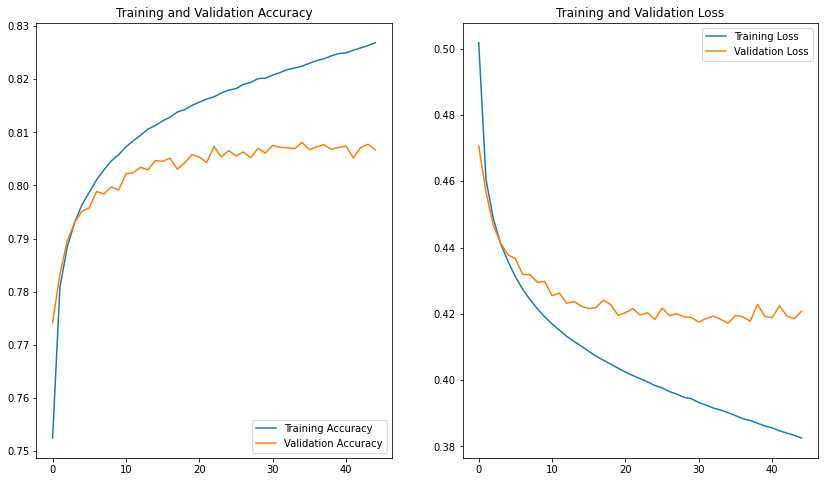

Maximum validation accuracy:  0.8081187605857849
Minimum loss: 0.4171757400035858


In [42]:
# Get the accuracy results for each epoch
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
# Get the loss results for each epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Get the epochs count
epochs_range = range(len(history.history["loss"]))

# Create the plot area
plt.figure(figsize=(14, 8))

# Setup the first colum : Accuracy plot
plt.subplot(1, 2, 1)
# Plot the training and validation accuracy for these epochs
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# Setup the legend
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Setup the second colum : Loss plot
plt.subplot(1, 2, 2)
# Plot the training and validation loss for these epochs
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
# Setup the legend
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

# Show the overall plot
plt.show()

position = np.argmax(history.history["val_accuracy"])
print(f"Maximum validation accuracy:  {history.history['val_accuracy'][position]}\nMinimum loss: {history.history['val_loss'][position]}")

In [43]:
best_accuracy = max(history.history["val_accuracy"])
print(f"Best validation accuracy : {best_accuracy}")

Best validation accuracy : 0.8081187605857849


### Print Classification Report

In [44]:
predictions = hybrid_cnn_lstm_model.predict(X_test)
predictions = np.where(predictions<0.5, 0, 1)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     79800
           1       0.81      0.80      0.81     80200

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000

